# **Pneumonia Detection AI - Pytorch Model**

<pre>
 Copyright (c) 2024 Aydin Hamedi
 
 This software is released under the MIT License.
 https://opensource.org/licenses/MIT
</pre>


In [1]:
# Error Suppressing >>>
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Main Libs >>>
import os
import gc
import glob
import time
import torch
import datetime
import numpy as np
import multiprocessing
from tqdm import tqdm
import seaborn as sns
from numba import cuda
from torch import nn
from tabulate import tabulate
import torchvision.utils as vutils
import torch_optimizer as TP_optim  # noqa: F401
import matplotlib.pyplot as plt
from torchsummary import summary
from numba.cuda.cudadrv import enums
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torchcam.utils import overlay_mask
from torchcam.methods import (
    GradCAM,
    GradCAMpp,
    SmoothGradCAMpp,
    ScoreCAM,
    SSCAM,
    ISCAM,
    XGradCAM,
    LayerCAM,
)

# Utils >>>
from Utils.Record_Var import Record_var
from Utils.print_color import print_colored as cprint
from Utils.Data_tools.Random_subset import random_subset
from Utils.Data_tools.Data_Loader import load_dataset
from Utils.Data_tools.normalization import compute_class_weights_one_hot
from Utils.Data_tools.augment_dat import augment_tensor
from Utils.Train_tools import Lr_schedulers
from Utils.Data_tools.RgbRandAugment import rgb_augmentation_transform
from Utils.Data_tools.Debug import save_samples
from Utils.Train_tools import Train_Report
from Utils.Train_tools.Training_utils import (
    eval,
    calc_metrics,
    EarlyStopping,
    EarlyStopping_LoadBest,
    TensorDataset_rtDTC,
    TensorDataset_rtIDT,
)

## Prep


In [2]:
# Conf >>>
CPU_only = False
Is_tensor = False
Is_loaded = False
np.random.seed(42)
torch.manual_seed(42)
torch.set_num_threads(multiprocessing.cpu_count())

# Get the current device info >>>
device_C = cuda.get_current_device()
attribs = [
    name.replace("CU_DEVICE_ATTRIBUTE_", "")
    for name in dir(enums)
    if name.startswith("CU_DEVICE_ATTRIBUTE_")
]

with open("GPU_Info.txt", "w") as f:
    for attr in attribs:
        f.write(f"{attr} = {getattr(device_C, attr)}\n")
# Get the current device for torch >>>
device = torch.device("cuda" if torch.cuda.is_available() and not CPU_only else "cpu")
print(f"Chosen device: {device}")
if device.type == "cuda":
    device_name = torch.cuda.get_device_name(device)
    device_capability = torch.cuda.get_device_capability(device)
    print(f"CUDA │ Device Name: {device_name}")
    print(f"CUDA │ Device Capability: {device_capability}")

Chosen device: cuda
CUDA │ Device Name: NVIDIA GeForce RTX 3090
CUDA │ Device Capability: (8, 6)


## Conf


In [3]:
# Main dataset dir
main_data_dir = ".\\Database\\Data"
# Cache dataset dir
cache_data_dir = ".\\Cache\\Dataset"
# Image debug dir
debug_dir = ".\\Debug\\Img_Samples\\Img_Loading"
# Image resolution
img_res = [224, 224]
# Data type
dtype = np.float16
# Split (Train&Test)
TT_split = 0.7
# class weighting method
class_weighting_method = "linear"

## Data Loading & Peprocessing


In [4]:
# Loading data >>>
Is_loaded = False
cprint("<Fore.YELLOW>Loading the data...")
# Define the data labels names
cprint(" │ <Fore.CYAN>Defining the data labels names...")
labels = [label.capitalize() for label in os.listdir(main_data_dir)]
num_classes = len(labels)
# Load the data
x_main, y_main = load_dataset(
    main_data_dir,
    Progbar_desc=cprint(" │ <Fore.CYAN>Loading the data", end="", return_string=True),
    print_sig=cprint(" │ <Fore.CYAN>", end="", return_string=True, reset=False),
    img_size=img_res,
    color_mode="rgb",
)
# Peprocessing data >>>
cprint("<Fore.YELLOW>Peprocessing the data...")
# One hot encode the labels
cprint(
    f" │ <Fore.CYAN>One hot encoding the labels... <Fore.GREEN>[num_classes: {num_classes}]"
)
y_main = np.eye(num_classes)[y_main].astype(np.float32)
# normalize the data
cprint(" │ <Fore.CYAN>Normalizing the data...")
x_main = x_main.astype(dtype) / 255.0
# Compute the class weights
cprint(" │ <Fore.CYAN>Computing the class weights...")
class_weights = compute_class_weights_one_hot(y_main, weighting=class_weighting_method)
# Saving Debugging images
cprint(f" │ <Fore.CYAN>Saving Debugging images... <Fore.GREEN>[dir: {debug_dir}]")
save_samples(
    *random_subset(x_main, y_main, 50), debug_dir, labels
)  # Save 50 random images
# Split the data into train and test sets
cprint(" │ <Fore.CYAN>Splitting the data into train and test sets...")
x_train, x_test, y_train, y_test = train_test_split(
    x_main, y_main, test_size=1 - TT_split, random_state=42
)
del x_main, y_main
# End >>>
Is_loaded = True
cprint("<Fore.YELLOW>Done!")

Loading the data...
 │ Defining the data labels names...
 │ Loading data from directory: .\Database\Data


 │ Loading the data: 100%|██████████| 2527/2527 [00:02<00:00, 994.46it/s] 


Peprocessing the data...
 │ One hot encoding the labels... [num_classes: 6]
 │ Normalizing the data...
 │ Computing the class weights...
 │ Saving Debugging images... [dir: .\Debug\Img_Samples\Img_Loading]
 │ Splitting the data into train and test sets...
Done!


## Cache Data (Use this to make the results more repeatable)


In [4]:
# Start
if Is_loaded:
    cprint(
        "<Fore.RED>Warning: <Fore.YELLOW>Dataset is already loaded! Updating the cache...<Fore.RESET>"
    )
    os.makedirs(cache_data_dir, exist_ok=True)
    [os.remove(file) for file in glob.glob(f"{cache_data_dir}/*.npz")]
    np.savez_compressed(
        f"{cache_data_dir}\\Data.npz",
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test,
        class_weights=class_weights,
        num_classes=num_classes,
        labels=labels,
    )
else:
    cprint("<Fore.GREEN>Loading Dataset From Cache...<Fore.RESET>")
    if os.path.exists(f"{cache_data_dir}\\Data.npz"):
        data = np.load(f"{cache_data_dir}\\Data.npz")
        x_train = data["x_train"]
        x_test = data["x_test"]
        y_train = data["y_train"]
        y_test = data["y_test"]
        class_weights = data["class_weights"]
        num_classes = int(data["num_classes"])
        labels = list(data["labels"])
        del data
    else:
        cprint(
            f"<Fore.RED>Error: <FOre.YELLOW>Failed to load dataset from cache! (No cache found at {cache_data_dir}\\Data.npz)"
        )
# End
cprint("<Fore.GREEN>Done.")

Loading Dataset From Cache...
Done.


## Data Analyzation


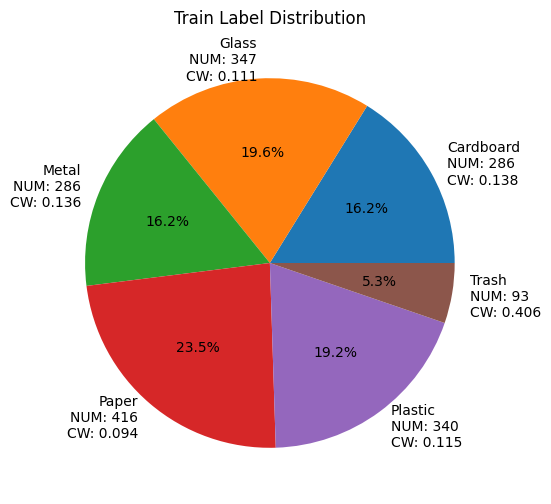

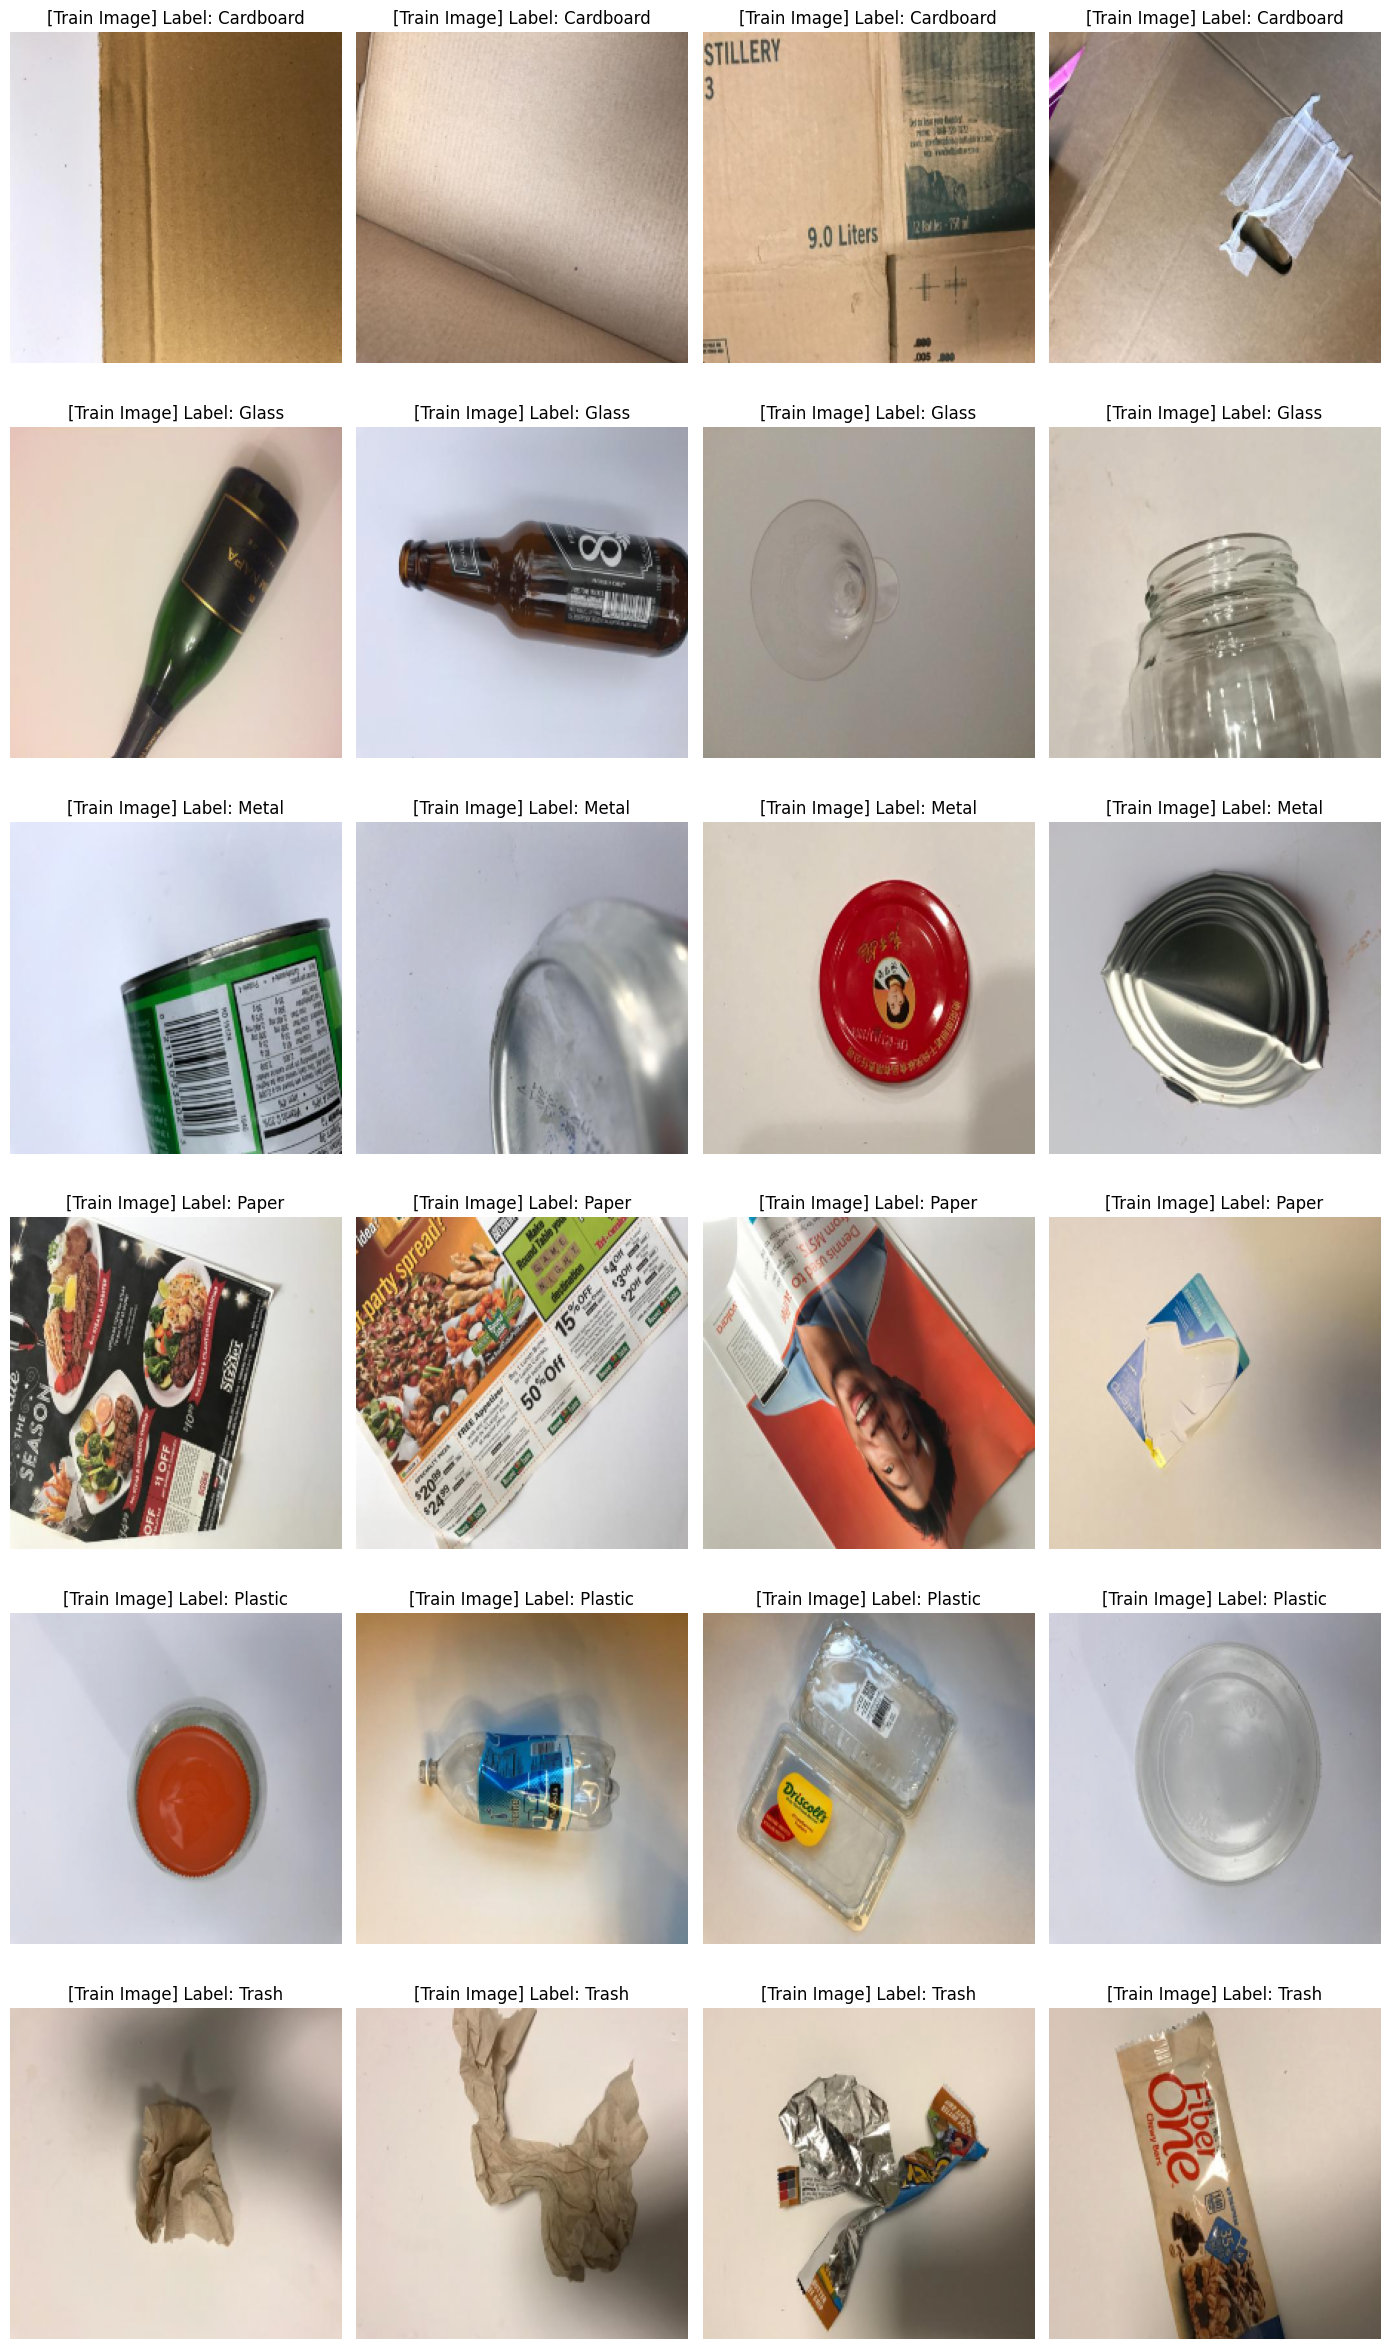

In [5]:
def plot_label_distribution(labels, labels_names, class_weights, title, subplot):
    # Convert one-hot encoded labels to class indices
    label_indices = np.argmax(labels, axis=1)

    _, counts = np.unique(label_indices, return_counts=True)

    # Convert counts to string and add to labels for pie chart
    labels_with_counts = [
        f"{label}\nNUM: {count}\nCW: {weight:.3f}"
        for label, count, weight in zip(labels_names, counts, class_weights)
    ]
    subplot.pie(counts, labels=labels_with_counts, autopct="%1.1f%%")
    subplot.set_title(title)


def plot_example_images(images, labels, labels_names, num_classes, title, subplot):
    # Convert one-hot encoded labels to class indices
    label_indices = np.argmax(labels, axis=1)

    unique_labels = np.arange(num_classes)

    for i, label in enumerate(unique_labels):
        # Get the indices of the images that have the current label
        indices = np.where(label_indices == label)[0]
        # Select four images from the current label
        selected_images = images[indices[:4]].astype(np.float32)
        for j, image in enumerate(selected_images):
            # Plot the image
            subplot[i, j].imshow(image)
            subplot[i, j].set_title(f"[{title}] Label: {labels_names[i]}")
            subplot[i, j].axis("off")


# Create subplots for label distributions
fig, axs = plt.subplots(1, 1, figsize=(18, 6))
plot_label_distribution(y_train, labels, class_weights, "Train Label Distribution", axs)
plt.show()

# Create subplots for example images
fig, axs = plt.subplots(num_classes, 4, figsize=(14, num_classes * 4))
plot_example_images(x_train, y_train, labels, num_classes, "Train Image", axs)
plt.tight_layout()
plt.show()

## Porting for pytorch


In [6]:
# Porting for pytorch
cprint("<Fore.YELLOW>Porting for pytorch...")
Is_tensor = True
x_train = torch.from_numpy(x_train).permute(0, 3, 1, 2)
x_test = torch.from_numpy(x_test).permute(0, 3, 1, 2)
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
class_weights = torch.from_numpy(class_weights)
# End
cprint("<Fore.GREEN>Done!")

Porting for pytorch...
Done!


## Models


### MaxViT


In [10]:
from vit_pytorch.max_vit import MaxViT

model = MaxViT(
    num_classes=2,
    dim_conv_stem=64,  # dimension of the convolutional stem, would default to dimension of first layer if not specified
    dim=96,  # dimension of first layer, doubles every layer
    dim_head=32,  # dimension of attention heads, kept at 32 in paper
    depth=(
        2,
        2,
        5,
        2,
    ),  # number of MaxViT blocks per stage, which consists of MBConv, block-like attention, grid-like attention
    window_size=7,  # window size for block and grids
    mbconv_expansion_rate=4,  # expansion rate of MBConv
    mbconv_shrinkage_rate=0.25,  # shrinkage rate of squeeze-excitation in MBConv
    dropout=0.1,  # dropout
    channels=3,
)

# Prep
model = model.to(device)

# Summary
summary(model, input_size=(3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]             640
            Conv2d-2         [-1, 64, 112, 112]          36,928
            Conv2d-3        [-1, 384, 112, 112]          24,960
       BatchNorm2d-4        [-1, 384, 112, 112]             768
              GELU-5        [-1, 384, 112, 112]               0
            Conv2d-6          [-1, 384, 56, 56]           3,840
       BatchNorm2d-7          [-1, 384, 56, 56]             768
              GELU-8          [-1, 384, 56, 56]               0
            Reduce-9                  [-1, 384]               0
           Linear-10                   [-1, 96]          36,864
             SiLU-11                   [-1, 96]               0
           Linear-12                  [-1, 384]          36,864
          Sigmoid-13                  [-1, 384]               0
        Rearrange-14            [-1, 38

### EfficientNet-B3

#### Best Results:

| Metric                           | Value     |
| -------------------------------- | --------- |
| Loss                             | 0.0766615 |
| F1 Score (macro)                 | 0.961329  |
| Precision (macro)                | 0.962022  |
| Recall (macro)                   | 0.961183  |
| AUROC                            | 0.990059  |
| Accuracy                         | 0.961357  |
| Cohen's Kappa                    | 0.922679  |
| Matthews Correlation Coefficient | 0.923204  |


In [10]:
# Add the model info
model_info = "Efficientnet-b3: Simple FC - dropout_rate=0.34"

# Load pre-trained EfficientNet-B3
model = EfficientNet.from_pretrained(
    "efficientnet-b3",
    include_top=True,
    num_classes=num_classes,
    in_channels=3,
    dropout_rate=0.34,
)

# Prep
model = model.to(device)

# Summary
summary(model, input_size=(3, 224, 224), device=str(device))

Loaded pretrained weights for efficientnet-b3
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 40, 112, 112]           1,080
       BatchNorm2d-3         [-1, 40, 112, 112]              80
MemoryEfficientSwish-4         [-1, 40, 112, 112]               0
         ZeroPad2d-5         [-1, 40, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 40, 112, 112]             360
       BatchNorm2d-7         [-1, 40, 112, 112]              80
MemoryEfficientSwish-8         [-1, 40, 112, 112]               0
          Identity-9             [-1, 40, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 10, 1, 1]             410
MemoryEfficientSwish-11             [-1, 10, 1, 1]               0
         Identity-12             [-1, 10, 1, 1]               0
Conv2dStaticSamePadding-13        

## Training System


In [11]:
# Conf Prep
try:
    [globals().pop(key) for key in Train_Confs]  # type: ignore  # noqa: F821
except Exception:
    pass
Conf_recorder = Record_var()
Conf_recorder.Start(globals()) # For capturing train configs
# fmt: off
# Conf >>> ------------------------------------------------------------------------------------------------ |
batch_size = 16  # Batch size (If you need to use a large batch size use gradient_accumulation to save memory)
max_epochs = 512  # Maximum number of epochs to train for
early_stop = True  # If True, the training will stop if the validation loss does not improve for n epochs
agmentation = True  # If True, the data will be augmented [Pre_epoch: before each epoch] - [runtime: during each epoch]
data_loader_workers_force = None  # Force the number of workers to be this value. If None, the number of workers will be set to the number of CPU cores.
augmentation_magnitude = 4  # 1-30 for when dynamic_agmentation_scaling is off
dynamic_agmentation_scaling = True  # if True, the magnitude will be scaled with the epoch
dynamic_agmentation_scaling_fn = lambda epoch: min(epoch / (68 / 30), 18) + 3  # output: magnitude (1-30) | input: epoch
early_stop_patience = 86  # After n epochs without improvement, stop training and load the best model
train_eval_portion = 0.12  # The proportion of the training data that it used to messure the model's performance on train data
gradient_clipping = True  # If True, the gradient will be clipped to a maximum value/norm (Pervent exploding gradients)
gradient_clipping_max = 1.0  # The maximum of the gradient
gradient_clipping_method = "Norm"  # "Norm" or "Value"
agmentation_method = "runtime"  # "runtime" (Slower-Stable-LowRamUsage) or "Pre_epoch" (Faster-Unstable-HighRamUsage)
gradient_accumulation = False  # If True, the gradient will be accumulated over multiple batches before being applied to the model. (To save memory if you need to use a large batch size)
gradient_accumulation_steps = 3  # The number of batches to accumulate the gradient over
stochastic_weight_averaging = True  # If True, the model will be averaged over the last n epochs
swa_epoch_start = 48  #  The epoch to start the stochastic weight averaging
swa_bn_update_freq = 5  #  The frequency of updating the batch normalization statistics
swa_disable_early_stop = False # If True, the early stopping will be disabled until the SWA start epoch
lr_scheduler_update_method = "Epoch"  # "Batch" or "Epoch"
profile_lr_scheduler = True  # If True, the learning rate scheduler will be profiled
Debug_freq = {"Augmentation_sample": 8}
# Conf Capture 
Train_Confs = Conf_recorder.Capture(globals()) # For capturing train configs
# Optimizers ---------------------------------------------------------------------------------------------- |
# optimizer = TP_optim.DiffGrad(
#     model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4
# )
# optimizer = TP_optim.AdaBound(
#     model.parameters(),
#     lr=0.001,
#     betas=(0.9, 0.999),
#     final_lr=0.1,
#     gamma=1e-3,
#     eps=1e-8,
#     weight_decay=0,
#     amsbound=True,
# )
# optimizer = (
#     TP_optim.PID(  # Can work better than SGD but needs tuning (integral & derivative)
#         model.parameters(),
#         lr=0.008,
#         momentum=0.9,
#         weight_decay=0.0005,
#         integral=3,
#         derivative=64,
#     )
# )
# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=0.001,
#     amsgrad=True,
#     weight_decay=5e-6,
# )
optimizer = torch.optim.SGD(model.parameters(), lr=0.0102, weight_decay=0.001, momentum=0.9, nesterov=True)
# optimizer = TP_optim.Lookahead(optimizer, k=6, alpha=0.7)
# Conf Recorder
Conf_recorder.Start(globals()) # For capturing the lr_scheduler
# Learning rate schedulers -------------------------------------------------------------------------------- |
def Epoch_to_Steps(epoch):
    return epoch * (len(y_train) // (batch_size * gradient_accumulation_steps if gradient_accumulation else batch_size))
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer,
#     three_phase=True,
#     max_lr=0.0075,
#     epochs=84,
#     pct_start=0.15,
#     final_div_factor=50,
#     steps_per_epoch=Epoch_to_Steps(1),
# )
lr_scheduler = Lr_schedulers.CosineAnnealingLR_Warmup(  # A type of Onecycle learning rate scheduler
    optimizer,
    warmup_iters=8,
    main_iters=39,
    lr_idling_iters=0,
    decay_iters=98,
    lr_main_min=0.006,  # 0.006
    lr_final_min=0.005,  # 0.002
    warmup_start=0.07,
)
swa_lr_scheduler = torch.optim.swa_utils.SWALR(optimizer, swa_lr=0.025)
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999, last_epoch=-1)
# Conf End <<< -------------------------------------------------------------------------------------------- |
# Conf Capture
Train_Confs.update(Conf_recorder.Capture(globals())) # For capturing the lr_scheduler
# fmt: on
# Prep
torch.cuda.empty_cache()
gc.collect()
cprint("<Fore.YELLOW>Starting the traning engine...")
History = {"Train": [], "Val": []}
Cache_dict = {}
if not Is_tensor:
    raise ValueError("You should port the data to pytorch tensors first!")
# loss_fn = nn.BCEWithLogitsLoss(weight=class_weights)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
log_dir_template = datetime.datetime.now().strftime("y%Y_m%m_d%d-h%H_m%M_s%S")
TB_log_dir = f"Logs\\Tensorboard\\{log_dir_template}"
TB_Data_writer = SummaryWriter(log_dir=f"{TB_log_dir}\\Data")
TB_Train_writer = SummaryWriter(log_dir=f"{TB_log_dir}\\Train")
TB_Val_writer = SummaryWriter(log_dir=f"{TB_log_dir}\\Validation")
train_reporter = Train_Report.Reporter(save_dir=f"Reports\\{log_dir_template}")
model = model.to(device)
Test_dataloader = DataLoader(
    dataset=TensorDataset_rtDTC(x_test, y_test),
    batch_size=batch_size * 2,
    shuffle=True,
    num_workers=os.cpu_count()
    if data_loader_workers_force is None
    else data_loader_workers_force,
    pin_memory_device=str(device),
    pin_memory=True,
    drop_last=False,
)
Augment_transformer = rgb_augmentation_transform(
    magnitude=dynamic_agmentation_scaling_fn(1)
    if dynamic_agmentation_scaling
    else augmentation_magnitude
)
if stochastic_weight_averaging:
    lr_scheduler_name = lr_scheduler.__class__.__name__
    lr_scheduler = torch.optim.lr_scheduler.SequentialLR(
        optimizer, [lr_scheduler, swa_lr_scheduler], milestones=[swa_epoch_start]
    )
    lr_scheduler.__class__.__name__ = lr_scheduler_name + "_SWA"
if profile_lr_scheduler:
    Lr_schedulers.Profile(
        lr_scheduler,
        Epoch_to_Steps(256) if lr_scheduler_update_method == "Batch" else 256,
        save_path=f"Reports\\{log_dir_template}\\.",
    )
Train_Confs[f"Opt_{optimizer.__class__.__name__}_Prams"] = optimizer.defaults
Train_Confs["model_info"] = {
    "model_class_name": model.__class__.__name__,
    "model_info": model_info,
}
# Stochastic Weight Averaging
if stochastic_weight_averaging:
    swa_model = torch.optim.swa_utils.AveragedModel(model)
# Verbose
cprint("<Fore.YELLOW>Setup verbose:")
cprint(f" │ <Fore.CYAN>Running on: <Fore.GREEN>{device}")
for key in Train_Confs:
    cprint(f" │ <Fore.CYAN>{key}: <Fore.GREEN>{Train_Confs[key]}")
cprint(f" │ <Fore.CYAN>Train Report dir: <Fore.GREEN>{f"Reports\\{log_dir_template}"}")
cprint(f" │ <Fore.CYAN>Tensorboard log dir: <Fore.GREEN>{TB_log_dir}")
cprint(" │ <Fore.CYAN>Adding tensorboard model graph...")
TB_Data_writer.add_graph(model, torch.rand(1, 3, 224, 224).to(device))
train_reporter.Add_Prams(Train_Confs)
# Traing start msg
cprint("<Fore.YELLOW>Starting the training...")
# Main training loop
try:
    for Epoch in range(1, max_epochs + 1):
        # Start msg + Start time
        cprint(
            f"\nEpoch: <Fore.CYAN>{Epoch}<Style.RESET_ALL>/<Fore.GREEN>{max_epochs} -->"
        )
        Epoch_start_time = time.time()
        # Data prep
        if dynamic_agmentation_scaling:
            Augment_transformer = rgb_augmentation_transform(
                magnitude=dynamic_agmentation_scaling_fn(Epoch)
            )
        if agmentation and agmentation_method == "Pre_epoch":
            x_train_aug = augment_tensor(
                x_train,
                Augment_transformer,
                Progbar_desc=cprint(
                    " │ <Fore.GREEN>Processing images<Style.RESET_ALL>",
                    return_string=True,
                    end="",
                ),
                mode="cpu" if CPU_only else "cuda",  # cuda for complex augmentations
                batch_size=128,
                proc_count=72,
            )
        # Data Debug samples
        img_samples_idx = np.random.choice(y_train.shape[0], size=50, replace=False)
        if agmentation:
            if agmentation_method == "Pre_epoch":
                img_samples = x_train_aug[img_samples_idx]
            else:
                img_samples = torch.stack(
                    [Augment_transformer(x_train[idx]) for idx in img_samples_idx]
                )
        else:
            img_samples = x_train[img_samples_idx]
        TB_Data_writer.add_image(
            "Debug/Train_input_img",
            vutils.make_grid(img_samples.cpu()[:16], nrow=4),
            Epoch,
        )
        if Epoch % Debug_freq["Augmentation_sample"] == 0 or Epoch == 1:
            cprint(" │ <Fore.GREEN>Saving Debug imgs...")
            save_samples(
                img_samples.cpu().permute(0, 2, 3, 1).numpy(),
                y_train[img_samples_idx].cpu().numpy(),
                "Debug\\Img_Samples\\Train_Aug\\",
                label_names=labels,
                jpeg_quality=95,
                verbose=False,
            )
        del img_samples_idx, img_samples
        # Data loader
        Train_dataloader = DataLoader(
            dataset=TensorDataset_rtIDT(
                x_train_aug
                if agmentation and agmentation_method == "Pre_epoch"
                else x_train,
                y_train,
                transformer=Augment_transformer,
            )
            if agmentation and agmentation_method == "runtime"
            else TensorDataset_rtDTC(
                x_train_aug
                if agmentation and agmentation_method == "Pre_epoch"
                else x_train,
                y_train,
            ),
            batch_size=batch_size,
            shuffle=True,
            num_workers=os.cpu_count()
            if data_loader_workers_force is None
            else data_loader_workers_force,
            pin_memory_device=str(device),
            pin_memory=True,
            drop_last=True,
        )
        # Train Prep
        Train_total_batches = (
            int(len(Train_dataloader) / gradient_accumulation_steps)
            if gradient_accumulation
            else len(Train_dataloader)
        )
        Train_dataloader_len = len(Train_dataloader)
        TrainEval_Data_len = round(Train_total_batches * train_eval_portion)
        TrainEval_Data = []
        batch_idx = 0
        loss_fn = loss_fn.to(device)
        model.train()
        # Tarin Verbose Prep
        cprint(
            f" │ <Fore.CYAN>Train Eval History len: <Fore.GREEN>{TrainEval_Data_len}/{Train_total_batches}"
        )
        cprint(f" │ <Fore.CYAN>Lr: <Fore.GREEN>{lr_scheduler.get_last_lr()[0]:.8f}")
        TB_Data_writer.add_scalar("Learning Rate", lr_scheduler.get_last_lr()[0], Epoch)
        # Train Progbar
        progress_bar = tqdm(
            total=Train_total_batches,
            desc=cprint(
                " │ <Fore.GREEN>Training<Style.RESET_ALL>", return_string=True, end=""
            ),
            unit="batch",
        )
        # Clean up
        torch.cuda.empty_cache()
        gc.collect()
        # Train Main
        for idx, (x, y) in enumerate(Train_dataloader):
            # Zero grad
            optimizer.zero_grad()
            # Forward pass + loss
            y_pred = model(x.to(device, non_blocking=True))
            loss = loss_fn(y_pred, y.to(device, non_blocking=True))
            if gradient_accumulation:
                loss = loss / gradient_accumulation_steps
            # Backward pass
            loss.backward()
            # Optimizer step
            if (
                not gradient_accumulation
                or ((idx + 1) % gradient_accumulation_steps == 0)
                or (idx + 1 == Train_dataloader_len)
            ):
                # Calculate the batch_idx
                batch_idx += 1
                # Gradient clipping
                if gradient_clipping:
                    match gradient_clipping_method:
                        case "Norm":
                            torch.nn.utils.clip_grad_norm_(
                                model.parameters(), gradient_clipping_max
                            )
                        case "Value":
                            torch.nn.utils.clip_grad_value_(
                                model.parameters(), gradient_clipping_max
                            )
                        case _:
                            raise ValueError(
                                "gradient_clipping_method must be one of: 'Norm', 'Value'"
                            )
                # Optimizer step
                optimizer.step()
                # Progress bar update
                progress_bar.update()
                # Lr scheduler step
                if lr_scheduler_update_method == "Batch":
                    lr_scheduler.step()
                # Weight Averaging Pram update
                if stochastic_weight_averaging and swa_epoch_start <= Epoch:
                    swa_model.update_parameters(model)
                # Train Eval Data
                if batch_idx >= (Train_total_batches - TrainEval_Data_len):
                    progress_bar.set_postfix_str("Recording Eval Data...")
                    TrainEval_Data.append(
                        {"y_pred": y_pred.detach().cpu(), "y": y.detach().cpu()}
                    )
        # Close progress bar
        progress_bar.close()
        # Lerning rate scheduler step + moving the loss to cpu + Weight Averaging bn update
        loss_fn = loss_fn.cpu()
        if lr_scheduler_update_method == "Epoch":
            lr_scheduler.step()
        if stochastic_weight_averaging and (
            Epoch % swa_bn_update_freq == 0 or Epoch == 1
        ):
            cprint(" │ <Fore.GREEN>Updating BN weight averaging...")
            torch.optim.swa_utils.update_bn(Train_dataloader, swa_model, device=device)
        # Val
        Train_eval = calc_metrics(
            torch.cat([item["y"] for item in TrainEval_Data]),
            torch.cat([item["y_pred"] for item in TrainEval_Data]),
            loss_fn,
        )
        Test_eval = eval(
            Test_dataloader,
            swa_model
            if (stochastic_weight_averaging and Epoch > swa_epoch_start)
            else model,
            device,
            loss_fn=loss_fn,
            TQDM_desc=cprint(
                f" │ <Fore.GREEN>Evaluating (Test{"-SWA" if (stochastic_weight_averaging and Epoch > swa_epoch_start) else ""})<Style.RESET_ALL>",
                end="",
                return_string=True,
            ),
        )
        # Clean up
        torch.cuda.empty_cache()
        gc.collect()
        # Saving the results
        History["Train"].append(Train_eval)
        History["Val"].append(Test_eval)
        # Print the results
        print(
            "\n".join(
                [
                    " │ " + row
                    for row in tabulate(
                        [
                            ["Train"]
                            + [f"{Train_eval[metric]:.8f}" for metric in Train_eval],
                            ["Test"]
                            + [f"{Test_eval[metric]:.8f}" for metric in Test_eval],
                        ],
                        headers=["Set"] + list(Train_eval.keys()),
                        tablefmt="grid",
                    ).split("\n")
                ]
            )
        )
        # Tensorboard logging
        for metric in Train_eval:
            TB_Train_writer.add_scalar(f"Metrics/{metric}", Train_eval[metric], Epoch)
            TB_Val_writer.add_scalar(f"Metrics/{metric}", Test_eval[metric], Epoch)
        # Early stopping
        if (
            stochastic_weight_averaging
            and Epoch < swa_epoch_start
            and swa_disable_early_stop
        ):
            cprint(
                " │ <Fore.YELLOW>EarlyStopping is Deactivated. It will be activated after the SWA start epoch"
            )
        elif EarlyStopping(
            Cache_dict,
            [Test_eval["F1 Score (macro)"], "max", "F1 Score"],
            Epoch,
            swa_model if stochastic_weight_averaging else model,
            "Cache\\weights",
            patience=early_stop_patience,
        ):
            break
        # End (Epoch Loop)
        Epoch_time = time.time() - Epoch_start_time
        TB_Data_writer.add_scalar("Epoch Time", Epoch_time, Epoch)
        cprint(
            f"Epoch {Epoch} finished.<Fore.GREEN> ("
            + (
                f"{int(Epoch_time // 60)}m {(Epoch_time % 60):.1f}s"
                if Epoch_time >= 60
                else f"{Epoch_time:.1f}s"
            )
            + ")"
        )
    # End (Training)
except KeyboardInterrupt:
    # interrupt msg
    cprint("<Fore.YELLOW>Training interrupted.")
    # Check if swa model was made
    if stochastic_weight_averaging and Epoch < swa_epoch_start:
        cprint(
            f"<Fore.RED>Warning:<Fore.YELLOW> SWA model was not made. {"The best model wont be loaded." if swa_disable_early_stop else "The best normal model will be loaded."}"
        )
    # Loading the best model
    EarlyStopping_LoadBest(
        swa_model
        if (stochastic_weight_averaging and Epoch > swa_epoch_start)
        else model,
        Cache_dict,
    )
# End (Training Engine)
train_reporter.Add_History(History)
train_reporter.Save_Report()
# TB_Data_writer.add_hparams(
#     hparam_dict={
#         f"{key}_{subkey}" if isinstance(value, dict) else key: subvalue
#         if isinstance(value, dict)
#         else value
#         for key, value in Train_Confs.items()
#         if not callable(value) and not isinstance(value, tuple)
#         for subkey, subvalue in (
#             value.items() if isinstance(value, dict) else [(key, value)]
#         )
#         if not isinstance(subvalue, tuple)
#     },
#     metric_dict={
#         "Train_abs_Acc": max([item["Accuracy"] for item in History["Train"]]),
#         "Test_abs_Acc": max([item["Accuracy"] for item in History["Val"]]),
#     },
# )
# Closing SummaryWriters
TB_Data_writer.close()
TB_Train_writer.close()
TB_Val_writer.close()
# Stochastic Weight Averaging
if stochastic_weight_averaging:
    cprint("<Fore.GREEN>Updating BN weight averaging...")
    torch.optim.swa_utils.update_bn(Train_dataloader, swa_model, device=device)
    for param, ema_param in zip(model.parameters(), swa_model.parameters()):
        param.data.copy_(ema_param.data)
    del swa_model
# End
cprint("<Fore.YELLOW>Training finished.")

Starting the traning engine...
Setup verbose:
 │ Running on: cuda
 │ batch_size: 16
 │ max_epochs: 512
 │ early_stop: True
 │ agmentation: True
 │ data_loader_workers_force: None
 │ augmentation_magnitude: 4
 │ dynamic_agmentation_scaling: True
 │ dynamic_agmentation_scaling_fn: <function <lambda> at 0x000002B1EFB972E0>
 │ early_stop_patience: 86
 │ train_eval_portion: 0.12
 │ gradient_clipping: True
 │ gradient_clipping_max: 1.0
 │ gradient_clipping_method: Norm
 │ agmentation_method: runtime
 │ gradient_accumulation: False
 │ gradient_accumulation_steps: 3
 │ stochastic_weight_averaging: True
 │ swa_epoch_start: 48
 │ swa_bn_update_freq: 5
 │ swa_disable_early_stop: False
 │ lr_scheduler_update_method: Epoch
 │ profile_lr_scheduler: True
 │ Debug_freq: {'Augmentation_sample': 8}
 │ Opt_SGD_Prams: {'lr': 0.0102, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0.001, 'nesterov': True, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None}
 │ Train Report dir: Repo

 │ Training: 100%|██████████| 110/110 [00:13<00:00,  8.28batch/s, Recording Eval Data...]


 │ Updating BN weight averaging...


 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.78batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.232917 |           0.279362 |            0.296643 |         0.275455 | 0.615776 |   0.299107 |        0.156137 |                           0.158042 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.230636 |           0.251506 |            0.338745 |         0.283806 | 0.642362 |   0.256917 |        0.12502  |                           0.13378  |
 │ +------

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.88batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.19835  |           0.460163 |            0.481498 |         0.515946 | 0.808926 |   0.477679 |        0.375777 |                           0.384308 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.220077 |           0.311675 |            0.543576 |         0.370771 | 0.747571 |   0.318841 |        0.217875 |                           0.252974 |
 │ +------

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.95batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.179655 |           0.562171 |            0.562502 |         0.594997 | 0.862651 |   0.575893 |        0.488474 |                           0.492927 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.197518 |           0.463088 |            0.627851 |         0.505415 | 0.838315 |   0.476943 |        0.384245 |                           0.414734 |
 │ +------

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.79batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.166781 |           0.507624 |            0.51539  |         0.553031 | 0.848651 |    0.53125 |        0.437764 |                           0.445652 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.172661 |           0.515707 |            0.651994 |         0.57709  | 0.871604 |    0.54282 |        0.456405 |                           0.48266  |
 │ +------

 │ Training: 100%|██████████| 110/110 [00:13<00:00,  8.43batch/s, Recording Eval Data...]


 │ Updating BN weight averaging...


 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.99batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.126382 |           0.650975 |            0.650448 |         0.690095 | 0.90584  |   0.674107 |        0.605776 |                           0.611162 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.167319 |           0.52541  |            0.625661 |         0.582647 | 0.867711 |   0.565217 |        0.472571 |                           0.494707 |
 │ +------

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.90batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.115831 |           0.664375 |            0.665595 |         0.68714  | 0.906703 |   0.714286 |        0.650784 |                           0.65446  |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.149397 |           0.582705 |            0.683657 |         0.623189 | 0.891695 |   0.621871 |        0.541287 |                           0.565842 |
 │ +------

 │ Evaluating (Test): 100%|██████████| 24/24 [00:07<00:00,  3.34batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.108429 |           0.701327 |            0.700766 |         0.723906 | 0.913799 |   0.727679 |        0.669481 |                           0.672183 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.129872 |           0.646784 |            0.712261 |         0.672895 | 0.906348 |   0.671937 |        0.601177 |                           0.618821 |
 │ +------

 │ Evaluating (Test): 100%|██████████| 24/24 [00:07<00:00,  3.29batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0988024 |           0.721728 |            0.715918 |         0.744502 | 0.92647  |   0.745536 |        0.69039  |                           0.692997 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.134234  |           0.607705 |            0.696142 |         0.644792 | 0.906931 |   0.638999 |        0.562183 |                           0.585712 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.78batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0796693 |           0.781632 |            0.771476 |         0.801339 | 0.946779 |   0.790179 |        0.742919 |                           0.744111 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.131727  |           0.633581 |            0.727311 |         0.660585 | 0.914457 |   0.662714 |        0.588969 |                           0.613075 |
 │ +

 │ Training: 100%|██████████| 110/110 [00:13<00:00,  8.15batch/s, Recording Eval Data...]


 │ Updating BN weight averaging...


 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.76batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.077711 |           0.789667 |            0.781062 |         0.80476  | 0.943907 |   0.8125   |        0.769463 |                           0.770012 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.126688 |           0.652479 |            0.72758  |         0.683204 | 0.922967 |   0.679842 |        0.611166 |                           0.632729 |
 │ +------

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.71batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0728449 |           0.775388 |            0.766392 |         0.804215 | 0.949459 |   0.785714 |        0.738381 |                           0.740121 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.130298  |           0.632118 |            0.722068 |         0.658438 | 0.919169 |   0.664032 |        0.590276 |                           0.612962 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.70batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0893323 |           0.736312 |            0.737422 |         0.738797 | 0.940334 |   0.75     |        0.693533 |                           0.694059 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.125974  |           0.644052 |            0.729028 |         0.672841 | 0.920783 |   0.667984 |        0.595875 |                           0.61844  |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.73batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0625525 |           0.81526  |            0.806496 |         0.835204 | 0.964676 |   0.830357 |        0.793072 |                           0.794418 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.126969  |           0.640634 |            0.71742  |         0.664082 | 0.918007 |   0.667984 |        0.595663 |                           0.615825 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.79batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0600341 |           0.792272 |            0.784777 |         0.858773 | 0.959163 |   0.830357 |        0.792365 |                           0.794754 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.133678  |           0.632002 |            0.73324  |         0.659371 | 0.926079 |   0.649539 |        0.574907 |                           0.603978 |
 │ +

 │ Training: 100%|██████████| 110/110 [00:13<00:00,  8.23batch/s, Recording Eval Data...]


 │ Updating BN weight averaging...


 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.75batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0629375 |           0.795978 |            0.790072 |         0.839109 | 0.951113 |   0.834821 |        0.797814 |                           0.799297 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.129488  |           0.653139 |            0.740289 |         0.673758 | 0.930621 |   0.666667 |        0.595989 |                           0.623096 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.92batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0459463 |           0.885919 |            0.872077 |         0.913296 | 0.969152 |   0.897321 |        0.87404  |                           0.875355 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.125148  |           0.664242 |            0.746823 |         0.689049 | 0.941102 |   0.679842 |        0.611922 |                           0.637984 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.93batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0686258 |           0.794124 |            0.79111  |         0.805754 | 0.957457 |   0.808036 |        0.766219 |                           0.767808 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.11715   |           0.684568 |            0.762815 |         0.70205  | 0.942756 |   0.703557 |        0.639283 |                           0.661716 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.98batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0540122 |           0.861195 |            0.85851  |         0.866888 | 0.971867 |   0.861607 |        0.830886 |                           0.831311 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.121147  |           0.671028 |            0.752867 |         0.690691 | 0.943784 |   0.681159 |        0.613263 |                           0.638348 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.89batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0508465 |           0.85514  |            0.846131 |         0.873776 | 0.970319 |   0.861607 |        0.830535 |                           0.832247 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.121194  |           0.665063 |            0.758388 |         0.686084 | 0.944232 |   0.674572 |        0.605541 |                           0.631707 |
 │ +

 │ Training: 100%|██████████| 110/110 [00:13<00:00,  7.92batch/s, Recording Eval Data...]


 │ Updating BN weight averaging...


 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.81batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0596322 |           0.822671 |            0.816201 |         0.838669 | 0.969396 |   0.84375  |        0.808799 |                           0.810274 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.114852  |           0.692297 |            0.742661 |         0.712928 | 0.939648 |   0.698287 |        0.633826 |                           0.651176 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.89batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0550139 |           0.885801 |            0.89032  |         0.88256  | 0.972702 |   0.892857 |        0.869651 |                           0.869905 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.141875  |           0.62514  |            0.732547 |         0.647039 | 0.930382 |   0.637681 |        0.560451 |                           0.590242 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.78batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0568389 |           0.840722 |            0.830038 |         0.859889 | 0.972861 |   0.852679 |        0.819817 |                           0.820816 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.116072  |           0.695043 |            0.765437 |         0.710243 | 0.950194 |   0.699605 |        0.635589 |                           0.658683 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.96batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0501462 |           0.882577 |            0.887151 |         0.880347 | 0.971969 |   0.883929 |        0.858114 |                           0.858407 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.106381  |           0.706891 |            0.758786 |         0.723699 | 0.951709 |   0.715415 |        0.654478 |                           0.671247 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.94batch/s]


 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |     Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+==========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.045139 |           0.851983 |            0.837942 |         0.873096 | 0.974124 |   0.848214 |        0.813607 |                           0.814009 |
 │ +-------+----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.10696  |           0.718689 |            0.77677  |         0.727577 | 0.958118 |   0.731225 |        0.672555 |                           0.688283 |
 │ +------

 │ Training: 100%|██████████| 110/110 [00:13<00:00,  8.17batch/s, Recording Eval Data...]


 │ Updating BN weight averaging...


 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.81batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0368278 |           0.882756 |            0.875217 |         0.894146 | 0.982395 |   0.888393 |        0.863817 |                           0.864154 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.118001  |           0.679106 |            0.762902 |         0.6924   | 0.953243 |   0.69697  |        0.631432 |                           0.653275 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.91batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0391263 |           0.899029 |            0.892283 |         0.907961 | 0.978822 |   0.910714 |        0.889845 |                           0.890241 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.124249  |           0.687699 |            0.758285 |         0.707907 | 0.952746 |   0.704875 |        0.64188  |                           0.662723 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.92batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0425498 |           0.854618 |            0.845901 |         0.870499 | 0.978833 |   0.879464 |        0.852217 |                           0.853376 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.105825  |           0.719453 |            0.776689 |         0.728666 | 0.96033  |   0.73386  |        0.676542 |                           0.694644 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:07<00:00,  3.29batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.040023  |           0.898099 |            0.882358 |         0.922833 | 0.977374 |   0.901786 |        0.878513 |                           0.879608 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0954208 |           0.744695 |            0.780226 |         0.758318 | 0.959218 |   0.758893 |        0.706748 |                           0.719213 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.52batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0429257 |           0.850504 |            0.841937 |         0.864221 | 0.978188 |   0.861607 |        0.830224 |                           0.830469 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0986591 |           0.734171 |            0.78092  |         0.743893 | 0.961646 |   0.73913  |        0.682921 |                           0.698474 |
 │ +

 │ Training: 100%|██████████| 110/110 [00:16<00:00,  6.78batch/s, Recording Eval Data...]


 │ Updating BN weight averaging...


 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.74batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0492557 |           0.876777 |            0.875283 |         0.881543 | 0.976054 |   0.875    |        0.847088 |                           0.847962 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.106267  |           0.714088 |            0.766035 |         0.729196 | 0.958789 |   0.719368 |        0.659199 |                           0.67695  |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.68batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0392759 |           0.852874 |            0.834662 |          0.89637 | 0.977292 |   0.870536 |        0.840354 |                           0.84251  |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0971814 |           0.708959 |            0.750011 |          0.7326  | 0.961172 |   0.72332  |        0.664802 |                           0.680785 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.84batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0429168 |           0.868729 |            0.859083 |         0.891672 | 0.977086 |   0.879464 |        0.853018 |                           0.854046 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.100849  |           0.715435 |            0.762251 |         0.734898 | 0.959981 |   0.727273 |        0.669265 |                           0.685957 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.51batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0473471 |           0.84738  |            0.835883 |         0.867243 | 0.96732  |   0.883929 |        0.855738 |                           0.857003 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0968438 |           0.771836 |            0.806564 |         0.781289 | 0.963724 |   0.782609 |        0.735356 |                           0.747604 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.82batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0430717 |           0.872377 |            0.855975 |         0.903169 | 0.975662 |   0.883929 |        0.857454 |                           0.858452 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.086173  |           0.777945 |            0.796875 |         0.797294 | 0.962799 |   0.785244 |        0.73941  |                           0.749581 |
 │ +

 │ Training: 100%|██████████| 110/110 [00:13<00:00,  8.18batch/s, Recording Eval Data...]


 │ Updating BN weight averaging...


 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.80batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0384065 |           0.897976 |            0.891724 |         0.905837 | 0.984712 |   0.919643 |        0.90137  |                           0.901617 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.105664  |           0.742059 |            0.784412 |         0.755006 | 0.96166  |   0.747036 |        0.693253 |                           0.710087 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.63batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0412108 |           0.869183 |            0.858719 |         0.884879 | 0.980129 |   0.897321 |        0.873552 |                           0.873858 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.106535  |           0.747323 |            0.794146 |         0.754224 | 0.957023 |   0.757576 |        0.704941 |                           0.720757 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.90batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0507996 |           0.836439 |            0.824576 |         0.853845 | 0.97464  |   0.84375  |        0.807158 |                           0.808102 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.122897  |           0.713666 |            0.777422 |         0.722657 | 0.954193 |   0.720685 |        0.660496 |                           0.681809 |
 │ +

 │ Evaluating (Test): 100%|██████████| 24/24 [00:06<00:00,  3.77batch/s]


 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Set   |      Loss |   F1 Score (macro) |   Precision (macro) |   Recall (macro) |    AUROC |   Accuracy |   Cohen's Kappa |   Matthews Correlation Coefficient |
 │ +=======+===========+====================+=====================+==================+==========+============+=================+====================================+
 │ | Train | 0.0555849 |           0.857407 |             0.85866 |         0.859232 | 0.973511 |   0.875    |        0.846071 |                           0.846424 |
 │ +-------+-----------+--------------------+---------------------+------------------+----------+------------+-----------------+------------------------------------+
 │ | Test  | 0.0944735 |           0.759725 |             0.79447 |         0.774854 | 0.965473 |   0.766798 |        0.717054 |                           0.730837 |
 │ +

 │ Training:  43%|████▎     | 47/110 [00:08<00:04, 15.65batch/s]

## Save model


In [9]:
# Start
cprint("<Fore.YELLOW>Saving model...")
torch.save(model, "model.pth")
# End
cprint("<Fore.GREEN>Model saved!")

Saving model...
Model saved!


## Loading model


In [7]:
# Start
cprint("<Fore.YELLOW>Loading model...")
if "model" in globals():
    cprint(
        "<Fore.RED>Warning:<Fore.YELLOW> A model is already loaded! Do you want to overwrite it? (y/n)"
    )
    if input("Do you want to overwrite it? (y/n)").lower() != "y":
        raise Exception("Model is not overwritten!")
    cprint("<Fore.YELLOW>Model is being overwritten!")
model = torch.load("model.pth")
# End
cprint("<Fore.GREEN>Model Loaded!")

Loading model...
Model Loaded!


## Analyse model Predicting performance


Analyzing model Predicting performance...


Evaluating: 100%|██████████| 48/48 [00:06<00:00,  7.32batch/s]

| Metric                           |     Value |
|----------------------------------|-----------|
| Loss                             | 0.0837889 |
| F1 Score (macro)                 | 0.806863  |
| Precision (macro)                | 0.817967  |
| Recall (macro)                   | 0.820927  |
| AUROC                            | 0.970568  |
| Accuracy                         | 0.83004   |
| Cohen's Kappa                    | 0.792823  |
| Matthews Correlation Coefficient | 0.798174  |


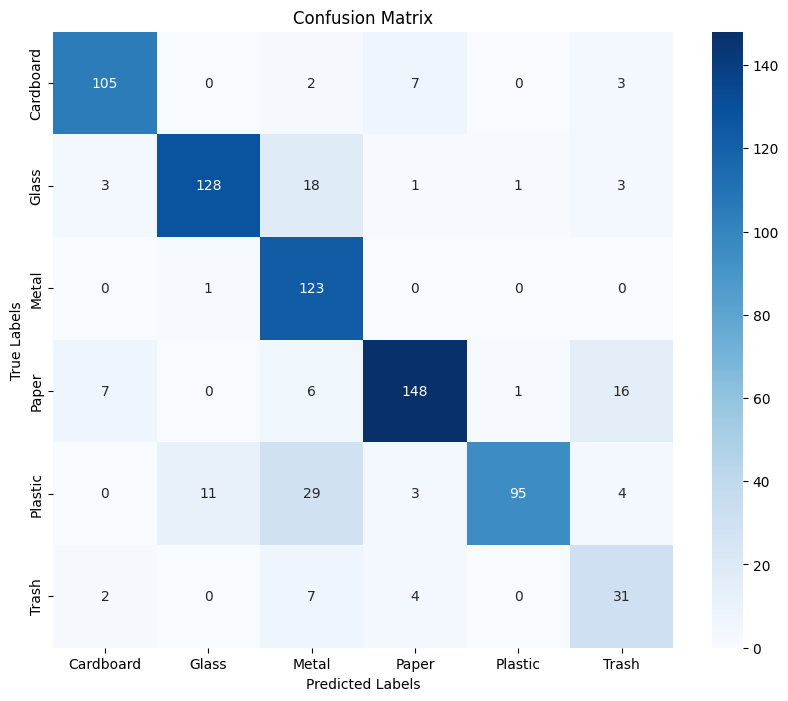

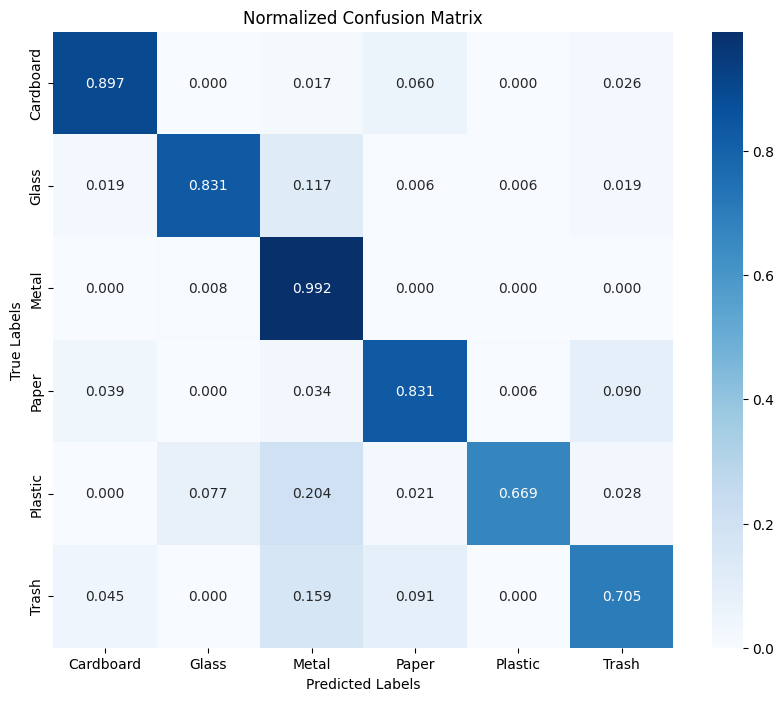












 │ Processing images: 10it [00:01,  5.13it/s]


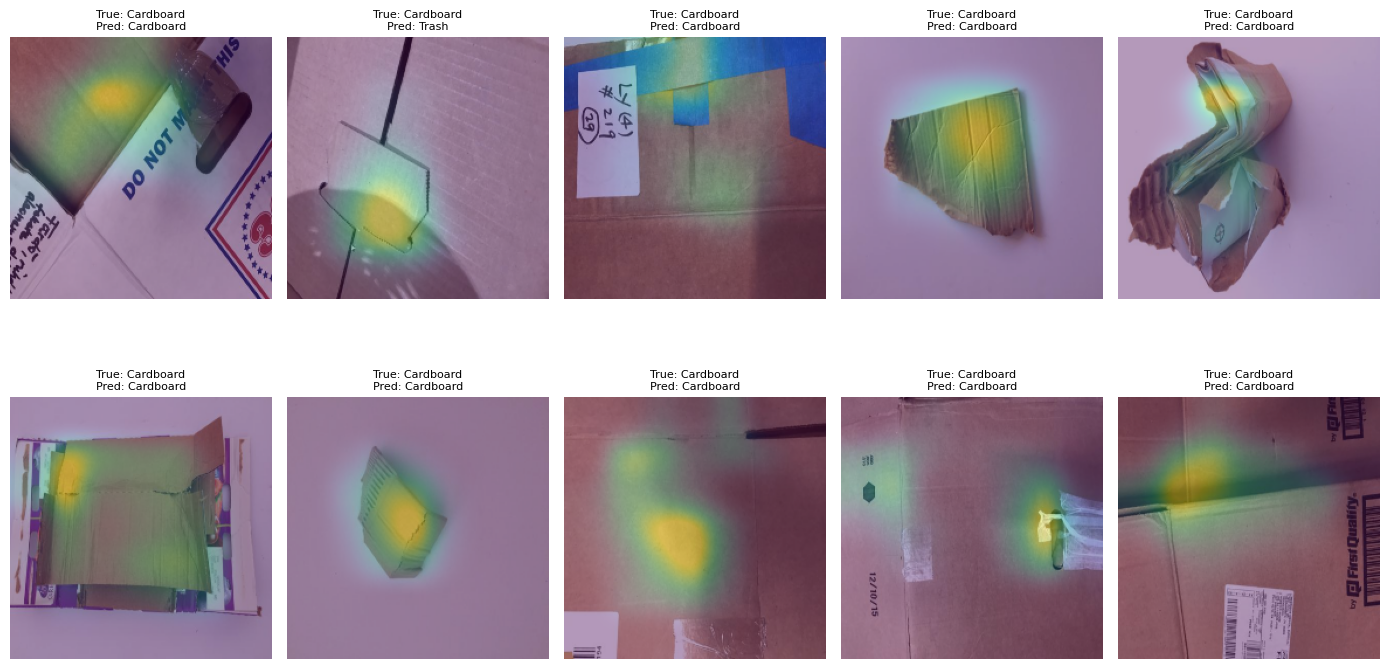












 │ Processing images: 10it [00:01,  5.30it/s]


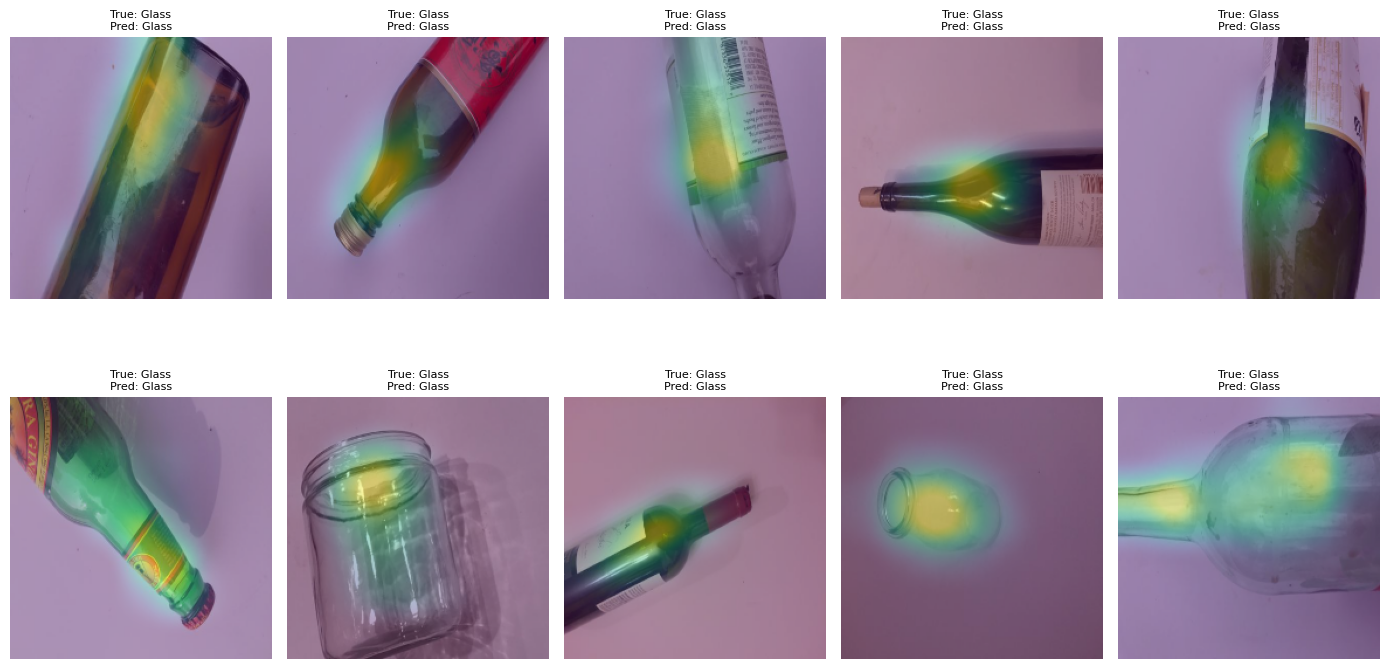












 │ Processing images: 10it [00:01,  5.02it/s]


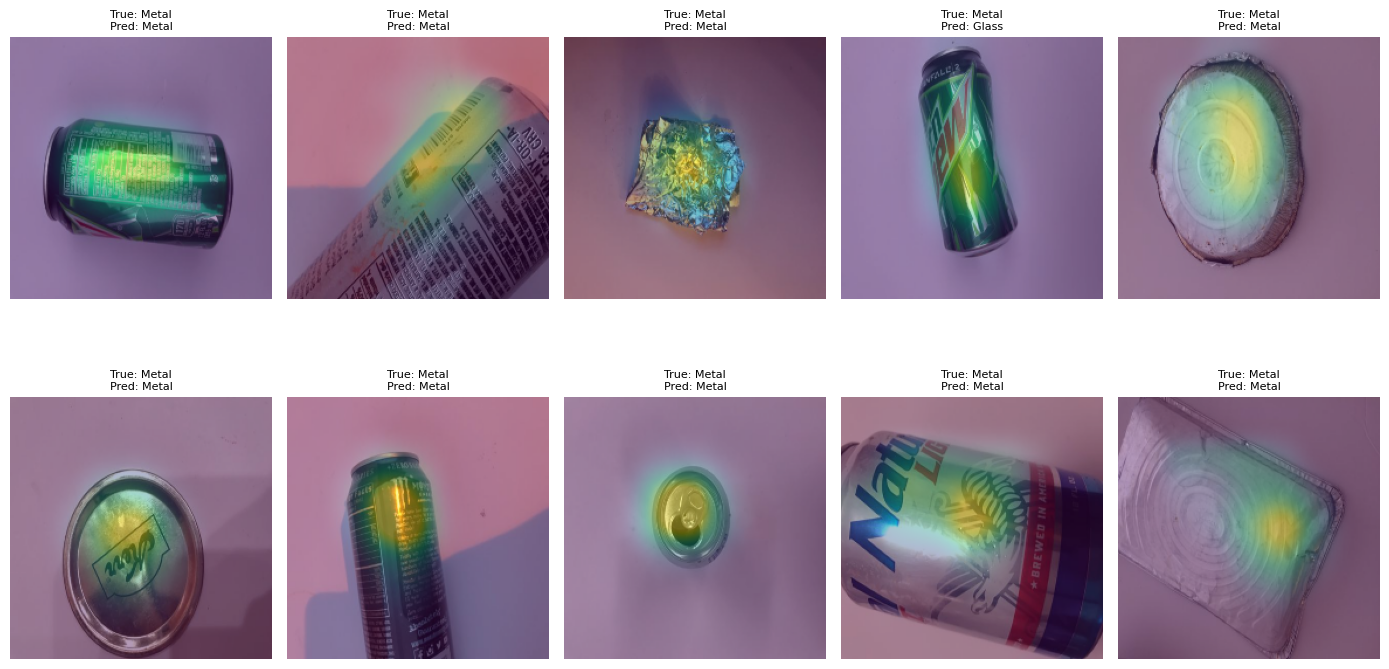












 │ Processing images: 10it [00:01,  5.31it/s]


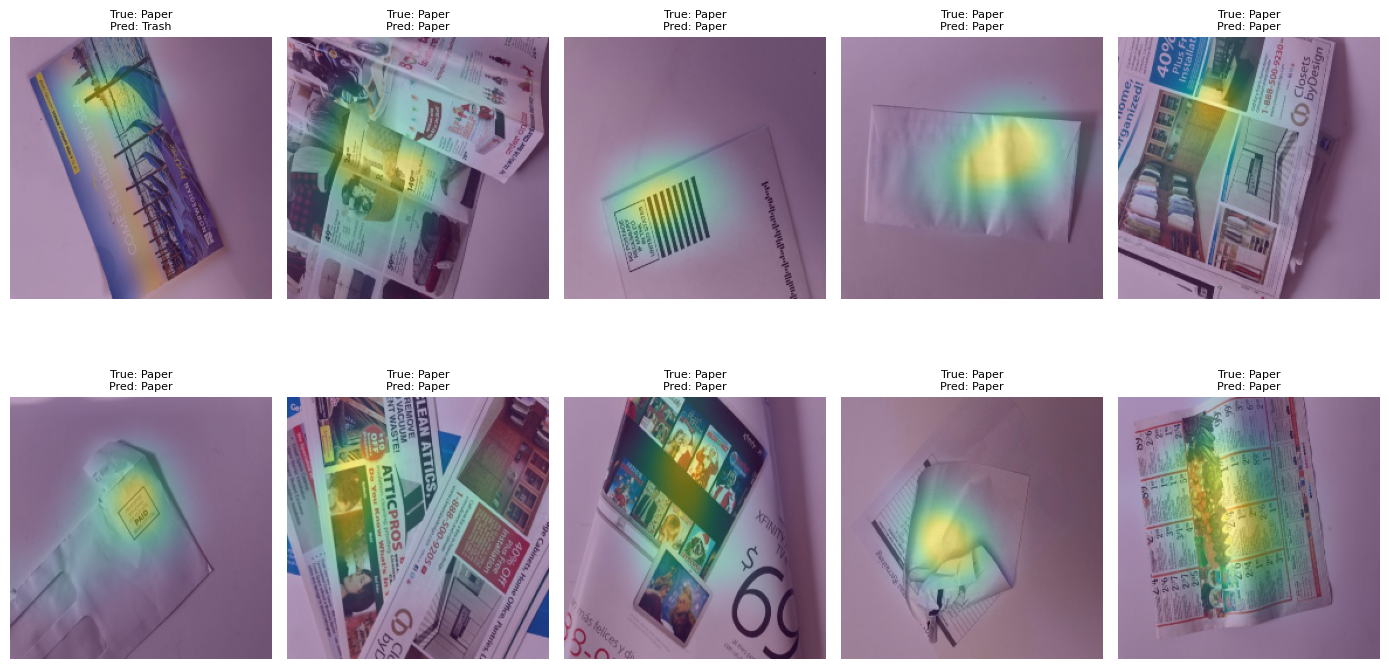












 │ Processing images: 10it [00:01,  5.17it/s]


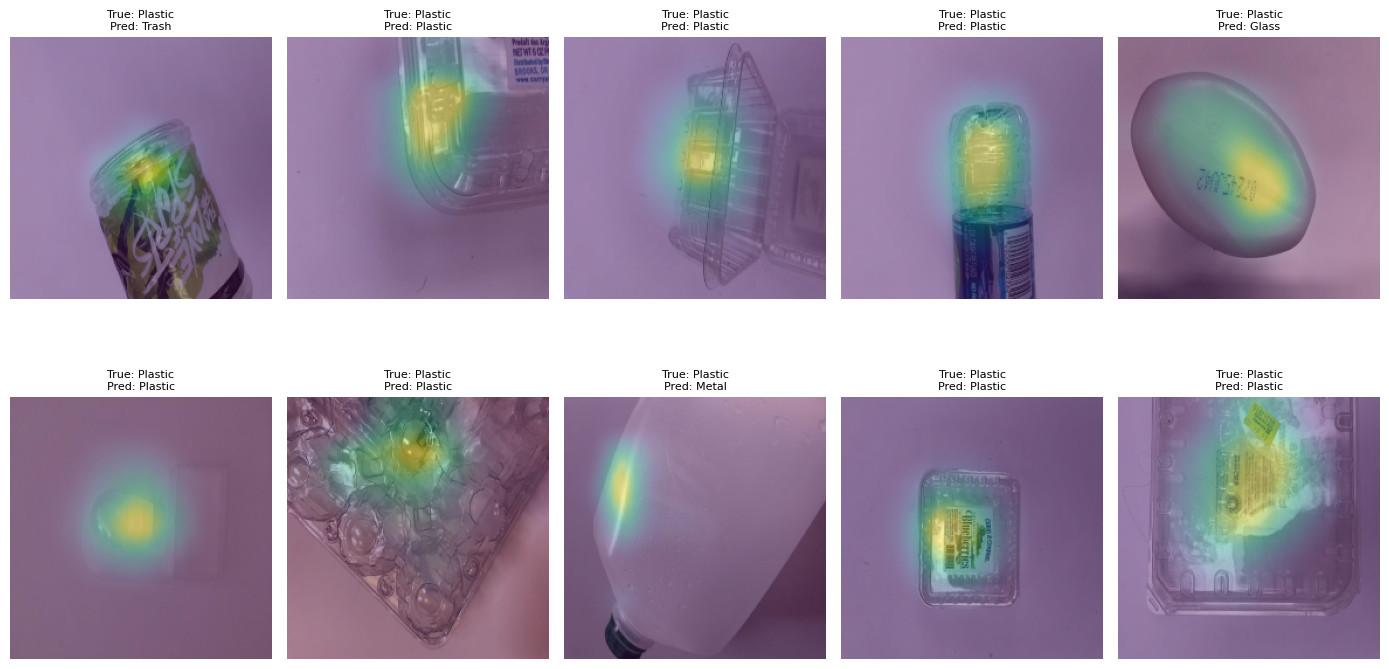












 │ Processing images: 10it [00:01,  5.16it/s]


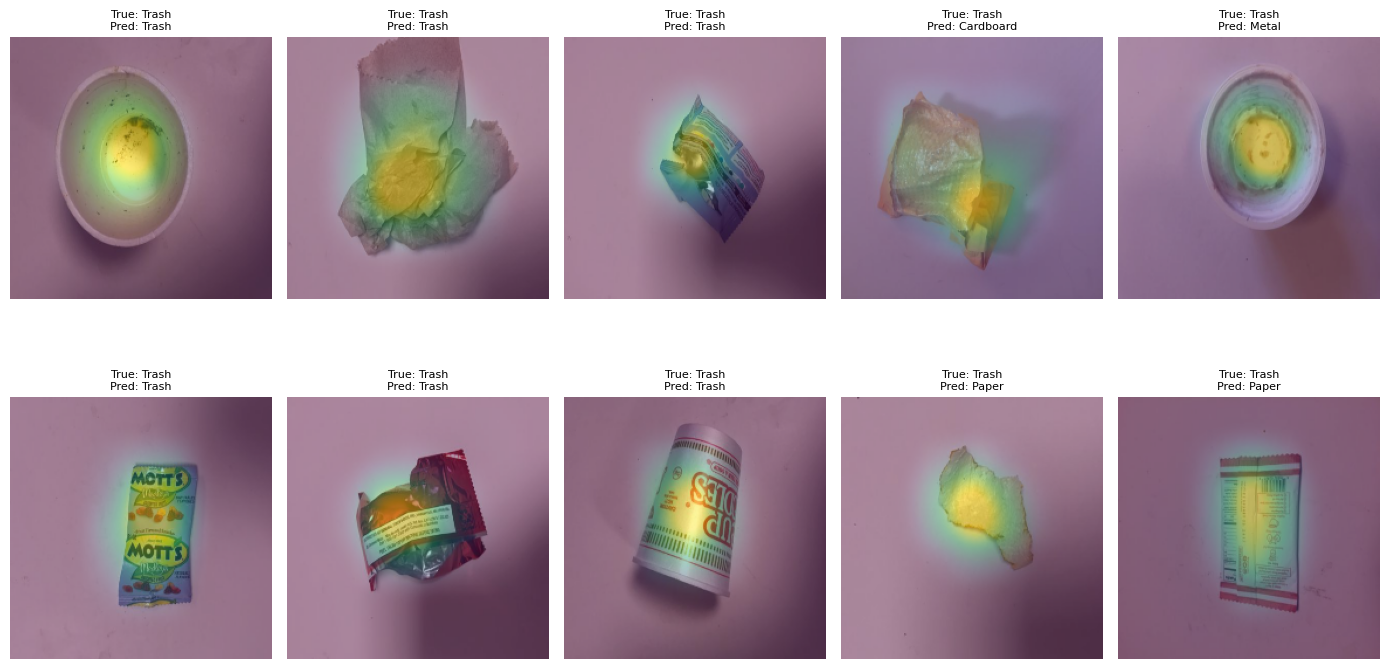

Making model activation map: 100%|██████████| 6/6 [00:13<00:00,  2.31s/it]

Model analyzation done.


In [11]:
# conf >>>
batch_size = 16
actCam_config = {
    "num_per_lable": 10,  # be divisible by 5
    "cam_method": "SmoothGradCAM++",  # ISCAM
    "target_layer": "_conv_head",
}
# Prep >>>
cprint("<Fore.YELLOW>Analyzing model Predicting performance...")
model = model.to(device)
Eval_dataloader = DataLoader(
    dataset=TensorDataset_rtDTC(x_test, y_test),
    batch_size=batch_size,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory_device=str(device),
    pin_memory=True,
    drop_last=False,
)
loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)

# Eval >>>
Eval_results, all_y_pred, all_y = eval(
    Eval_dataloader,
    model,
    device,
    loss_fn,
    verbose=True,
    return_preds=True,
    TQDM_desc=cprint(
        "<Fore.GREEN>Evaluating<Style.RESET_ALL>", end="", return_string=True
    ),
)

# Print Results >>>
print(tabulate(Eval_results.items(), headers=["Metric", "Value"], tablefmt="github"))

# Standard Confusion Matrix >>>
conf_matrix = confusion_matrix(all_y.argmax(dim=1), all_y_pred.argmax(dim=1))
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Normalized Confusion Matrix >>>
conf_matrix_normalized = confusion_matrix(
    all_y.argmax(dim=1), all_y_pred.argmax(dim=1), normalize="true"
)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_normalized,
    annot=True,
    fmt=".3f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Confusion Matrix")
plt.show()

# Activation Maps >>>
# Dict of the CAM methods to use
cam_methods = {
    "GradCAM": GradCAM,
    "GradCAM++": GradCAMpp,
    "SmoothGradCAM++": SmoothGradCAMpp,
    "ScoreCAM": ScoreCAM,
    "SSCAM": SSCAM,
    "ISCAM": ISCAM,
    "XGradCAM": XGradCAM,
    "LayerCAM": LayerCAM,
}
for Label in tqdm(
    labels,
    desc=cprint(
        "<Fore.GREEN>Making model activation map<Style.RESET_ALL>",
        end="",
        return_string=True,
    ),
):
    # Setting the plot fig size + tqdm sep
    print("")
    plt.figure(figsize=(14, (actCam_config["num_per_lable"] // 5) * 4))
    # Getting the samples
    x_samples, y_samples = random_subset(
        x_test,
        y_test,
        num=actCam_config["num_per_lable"],
        label_list=[labels.index(Label)],
    )
    for idx, (x, y) in tqdm(
        enumerate(zip(x_samples, y_samples)),
        desc=cprint(
            " │ <Fore.CYAN>Processing images<Style.RESET_ALL>",
            end="",
            return_string=True,
        ),
    ):
        # Getting the activation map
        cam_method = cam_methods[actCam_config["cam_method"]]
        with cam_method(
            model, actCam_config["target_layer"], input_shape=(x.shape[-1], *img_res)
        ) as cam_extractor:
            # Pred
            model_pred = model(x.to(device).unsqueeze(0).float())
            # Make the activation map
            activation_map = cam_extractor(
                model_pred.squeeze(0).argmax().item(), model_pred
            )
        # Overlay the activation map on the image
        combined_image = overlay_mask(
            to_pil_image(x),
            to_pil_image(activation_map[0].squeeze(0), mode="F"),
            colormap="viridis",
            alpha=0.6,
        )
        plt.subplot(actCam_config["num_per_lable"] // 5, 5, idx + 1)
        plt.imshow(combined_image)
        plt.title(
            f"True: {labels[y.argmax().item()]}\nPred: {labels[model_pred.squeeze().argmax().item()]}",
            fontsize=8,
        )
        plt.axis("off")
    plt.tight_layout()
    plt.show()
# End
cprint("<Fore.GREEN>Model analyzation done.")